## "Normale" und Convolutional Neural Networks

Am Beispiel des [CIFAR-10 Datensatzes](https://www.cs.toronto.edu/~kriz/cifar.html) wollen wir Unterschiede zwischen "normalen" und Convolutional Neural Networks (CNN) untersuchen. 

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64
num_workers = 10

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


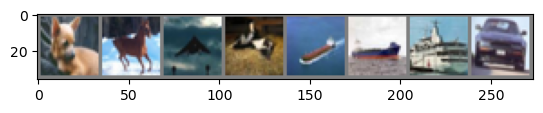

     dog     horse   plane   cat     ship    ship    ship    car    


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:8]))
# print labels
print('     ' + ' '.join(f'{classes[labels[j]]:7s}' for j in range(8)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 200)
        self.fc2 = nn.Linear(200, 150)
        self.fc3 = nn.Linear(150, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
import torch.optim as optim
from tqdm.notebook import tqdm

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train(model, epochs=10, criterion=None, optimizer=None, device=None):
    
    print(f"training model with {count_parameters(model)} parameters")
    
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
        
    if optimizer is None:
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    if device is None:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(f"Using {device} for training")
    
    model = model.to(device)
    learn_data = []
    
    with  tqdm(range(epochs)) as iterator:
        for epoch in iterator:  # loop over the dataset multiple times

            correct = 0
            total = 0
            running_loss = 0.0
            count = 0
            for data in trainloader:
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data[0].to(device), data[1].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # print statistics
                running_loss += loss.item()
                count += 1

            train_loss = running_loss/count
            train_accuracy = 100 * correct / total

            correct = 0
            total = 0
            running_loss = 0
            count = 0
            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)

                    # calculate outputs by running images through the network
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()
                    count += 1

                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            test_loss = running_loss/count
            test_accuracy = 100 * correct / total

            learn_data.append({ "train_loss": train_loss, "test_loss": test_loss, "train_accuracy": train_accuracy, "test_accuracy": test_accuracy })
            iterator.set_postfix_str(f"train_loss: {train_loss:.2f}, test_loss: {test_loss:.2f}, train_accuracy: {train_accuracy:.2f}%, test_accuracy: {test_accuracy:.2f}%")

    return learn_data


In [7]:
def plot(learn_data):
    
    fig, ax1 = plt.subplots()
    ax1.plot([ data["train_accuracy"] for data in learn_data ], label="train_acc")
    ax1.plot([ data["test_accuracy"] for data in learn_data ], label="test_acc")
    ax1.legend()
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("accuracy")
    ax1.plot()
    
    ax2 = ax1.twinx()
    ax2.plot([ data["train_loss"] for data in learn_data ], ':', label="train_loss")
    ax2.plot([ data["test_loss"] for data in learn_data ], ':', label="test_loss")
    ax2.legend()
    ax2.set_ylabel("loss")
    ax2.plot()

training model with 646260 parameters
Using cuda:0 for training


  0%|          | 0/20 [00:00<?, ?it/s]

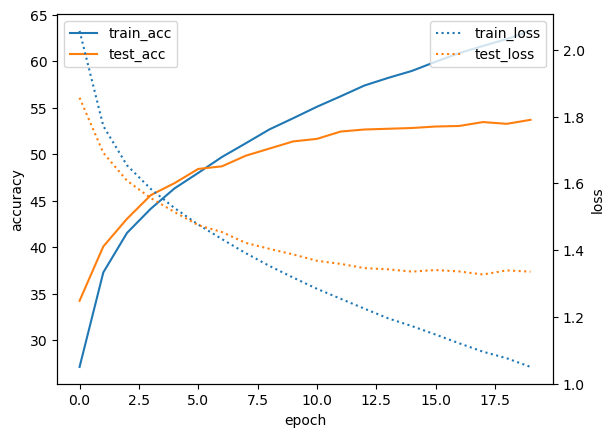

In [9]:
net = Net()
learn_data = train(net, epochs=20)
plot(learn_data)

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding="same")
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding="same")
        self.conv4 = nn.Conv2d(64, 64, 3, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

training model with 443218 parameters
Using cuda:0 for training


  0%|          | 0/20 [00:00<?, ?it/s]

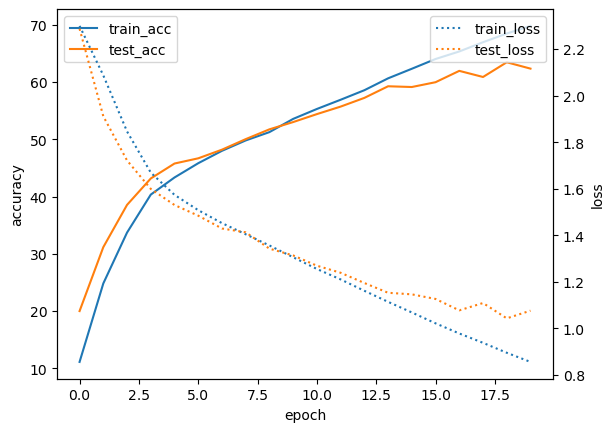

In [12]:
model = CNN()
learn_data = train(model, epochs=20)
plot(learn_data)

In [13]:
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding="same")
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding="same")
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, stride=2)
        self.batchnorm4 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 7 * 7, 120)
        self.batchnorm5 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.relu(self.batchnorm3(self.conv3(x)))
        x = F.relu(self.batchnorm4(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.batchnorm5(self.fc1(x)))
        x = self.fc2(x)
        return x

training model with 443842 parameters
Using cuda:0 for training


  0%|          | 0/10 [00:00<?, ?it/s]

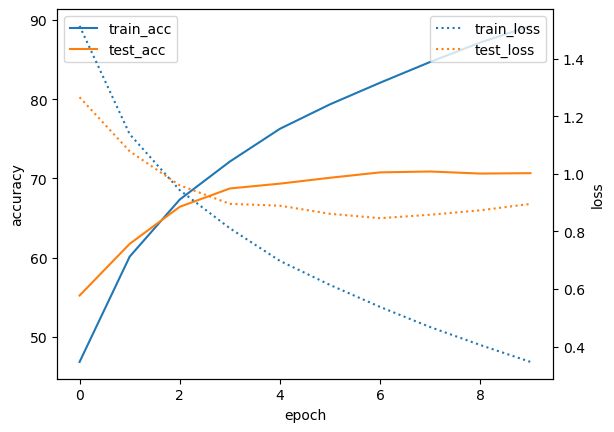

In [14]:
net = CNN2()
#optimizer = optim.AdamW(net.parameters(), lr=0.0005)
learn_data = train(net)
plot(learn_data)

In [15]:
class CNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding="same")
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout2d(p=0.2)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding="same")
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, stride=2)
        self.batchnorm4 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 7 * 7, 120)
        self.batchnorm5 = nn.BatchNorm1d(120)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = self.dropout1(x)
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = self.dropout1(x)
        x = F.relu(self.batchnorm3(self.conv3(x)))
        x = self.dropout1(x)
        x = F.relu(self.batchnorm4(self.conv4(x)))
        x = self.dropout1(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.batchnorm5(self.fc1(x)))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

training model with 443842 parameters
Using cuda:0 for training


  0%|          | 0/50 [00:00<?, ?it/s]

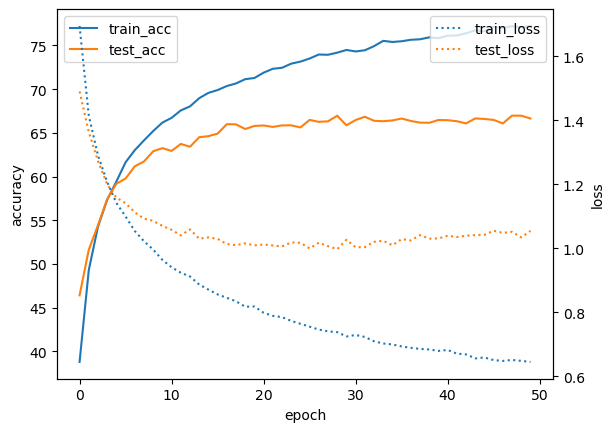

In [16]:
net = CNN3()
optimizer = optim.AdamW(net.parameters(), lr=0.0005)
learn_data = train(net, optimizer=optimizer, epochs=50)
plot(learn_data)

In [ ]:
3136/64